In [5]:
using JuMP
using GLPK
#using Xpress
using LinearAlgebra,Cbc
using Plots

# Question 1
$$\text{ max } 4x_1 + 3x_2$$
$$\text{subject to }x_1 + x_2 ≤ 4$$
$$2x_1 + x_2 ≤ 6$$
$$x_1, x_2 ≥ 0$$

#### Dual Program is

$$\text{ min } 6y_1 + 4y_2$$
$$\text{ subject to } $$
$$2y_1 + y_2 \ge 4$$
$$y_1 + y_2 \ge 3$$
$$y_1, y_2 \ge 0$$

In [ ]:
dual1 = Model(GLPK.Optimizer)
@variable(dual1, y1 >= 0)
@variable(dual1, y2 >= 0)
@constraint(dual1, 2y1 + y2 >= 4) # (y1 = 0, y2 = 4), (y1 = 2, y2 = 0)
@constraint(dual1, y1 + y2 >= 3)  # (y1 = 0, y2 = 3), (y1 = 3, y2 = 0)
@objective(dual1, Min, 6y1 + 4y2) # y1 = (-2/3)y2: (-2/3, y2 = 1), (-4/3, y2 = 2)
optimize!(dual1)
println("Optimal value = ", objective_value(dual1))
println("y1 = ", value(y1))
println("y2 = ", value(y2))

Optimal value = 14.0
y1 = 1.0
y2 = 2.0


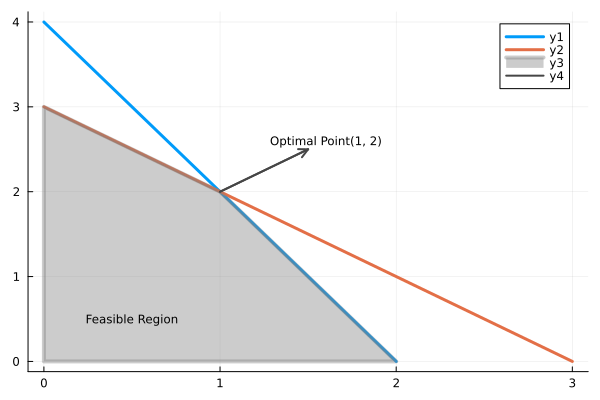

In [17]:
# Graphical Method
x1 = [0,2]; y1 = [4,0] 
x2 = [0,3]; y2 = [3,0]

# Plotting constraint lines
p1 = plot(x1, y1,lw=3, annotation=[(20,180,"2y1 + y2 = 4",6)])
p2 = plot!(p1, x2, y2, lw=3, annotation=[(15,122,"y1 + y2 = 3",6)])

x=[0, 0, 1, 2, 0]; y=[0, 3, 2, 0, 0]
p3=plot!(p2,x,y,palette = cgrad(:grays),lw=4, fill = 0, α = 0.4,annotation=[(0.5,0.5,"Feasible Region",8)])

p4=plot!(p3,[1, 1.5],[2,2.5],lw=2,arrow=0.4,annotation=[(1.6,2.6,"Optimal Point(1, 2)",8)])



# Question 2
![Screenshot 2025-10-23 at 14.26.06.png](<attachment:Screenshot 2025-10-23 at 14.26.06.png>)
We number the edges as in the figure

Now let set $S_i$ represent node i-th which cover the its adjecent edges.

$S_1$ = { 1, 4, 7 } <br>
$S_2$ = { 1, 2, 5 } <br>
$S_3$ = { 2, 3, 6 } <br>
$S_4$ = { 4, 5, 10 } <br>
$S_5$ = { 3, 8, } <br>
$S_6$ = { 7, 9, } <br>
$S_7$ = { 9, 10, 11 } <br>
$S_8$ = { 6, 8, 11 } <br>


We model this problem to choose minimum number of sets (nodes) to cover all edges.
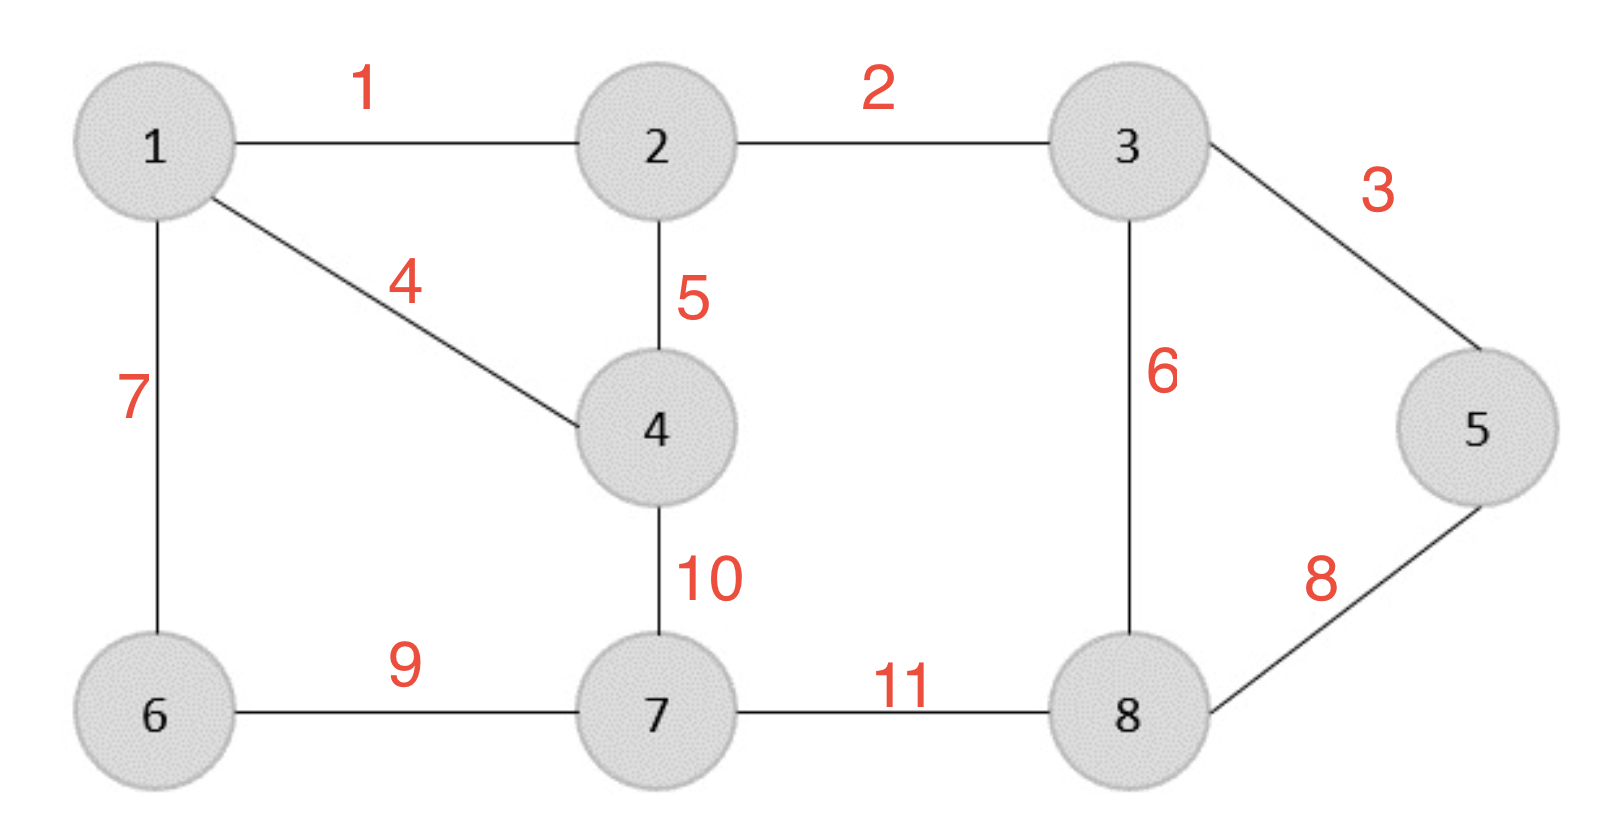

In [47]:
S = [1 2 3 4 5 6 7 8 9 10 11] # Universal Set (corresponding to edges)
y = [1 0 0 1 0 0 1 0 0 0 0; 
     1 1 0 0 1 0 0 0 0 0 0; 
     0 1 1 0 0 1 0 0 0 0 0; 
     0 0 0 1 1 0 0 0 0 1 0; 
     0 0 1 0 0 0 0 1 0 0 0; 
     0 0 0 0 0 0 1 0 1 0 0; 
     0 0 0 0 0 0 0 0 1 1 1; 
     0 0 0 0 0 1 0 1 0 0 1]
n = length(S)
m = 8

Set_Cover = Model(GLPK.Optimizer)

@variable(Set_Cover, x[1:m],Bin )

for i in 1:n
    @constraint(Set_Cover, (dot(x,y[:,i]))>=1)
end

@objective(Set_Cover,Min,sum(x[i] for i=1:m))

optimize!(Set_Cover)
println("Objective value: ",objective_value(Set_Cover))
    subsets=Matrix{Float64}(undef, 1, m)
for i in 1:m
        subsets[i]=value(x[i])
end
println("Selected Subsets: ",subsets)
    

Objective value: 5.0
Selected Subsets: [1.0 1.0 1.0 0.0 1.0 0.0 1.0 0.0]


# Question 3

Given a number of points in the 2D Cartesian plane, we want to find a line which maximize the margin $\delta$

Let the line be y = Ax + B.
For each point ($x_0$, $y_0$), the $\delta$ to the line is the distance between ($x_0$, $y_0$) and ($x_0$, $Ax_0 + B$), <br> which is $\delta = \sqrt{ (x_0 - x_0)^2 + (y_0 - Ax_0 - B)^2 } = \sqrt{ (y_0 - Ax_0 - B)^2 } = |y_0 - Ax_0 - B|$. 

By hypothesis, $\delta \ge 0$ for Apples and $\delta \le 0$ for Pears

The objective is to find A, B which minimize  $\sum{(Apple_{i,y} - A \cdot Apple_{i, x} - B)} + \sum{(- Pear_{i,y} + A \cdot Pears_{i, x} + B)}$ <br>
Subject to $$(Apple_{i,y} - A \cdot Apple_{i, x} - B) \ge 0$$
$$(- Pear_{i,y} + A \cdot Pears_{i, x} + B) \ge 0$$
$$ A, B \ge 0 $$

where <br>
$Apple_{i, x}, Apple_{i, y}$ are coordinate x and y of the point $Apple_i$ correspondingly <br>
$Pear_{i, x}, Pear_{i, y}$ are coordinate x and y of the point $Pear_i$ correspondingly 

In [90]:
point_Apple = [(60, 62), (55, 50), (65, 68), (55, 56), (68, 65), (60, 58)]
point_Pear = [(70, 53), (76, 40), (68, 45), (63, 45)]

N = length(point_Apple)
M = length(point_Pear)
model = Model(GLPK.Optimizer)
@variable(model, A)
@variable(model, B)
for i in 1:N
    print(point_Apple[i])
    @constraint(model, point_Apple[i][2] - A * point_Apple[i][1] - B >= 0)
end
for i in 1:M
    @constraint(model, -point_Pear[i][2] + A * point_Pear[i][1] + B >= 0)
end
@objective(model, Min, 
    sum(point_Apple[i][2] - A * point_Apple[i][1] - B for i in 1:N) + 
    sum(-point_Pear[i][2] + A * point_Pear[i][1] + B for i in 1:M)
)
optimize!(model)
println("Minimum delta = ", objective_value(model))
println("The line is y = ", value(A), "x", " + ", value(B))

(60, 62)(55, 50)(65, 68)(55, 56)(68, 65)(60, 58)Minimum delta = 80.8
The line is y = 0.2000000000000001x + 38.99999999999999


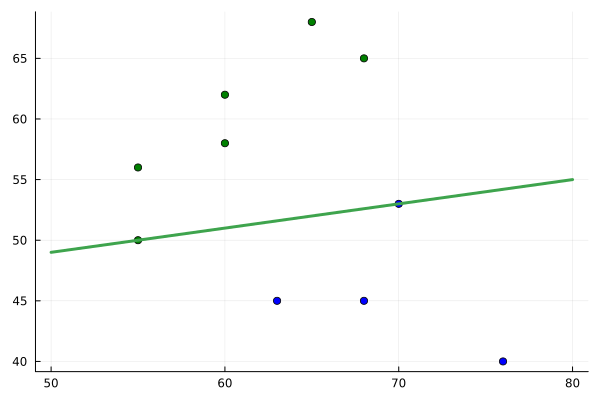

In [ ]:
Apple_x = [p[1] for p in point_Apple]
Apple_y = [p[2] for p in point_Apple]
Pear_x = [p[1] for p in point_Pear]
Pear_y = [p[2] for p in point_Pear]
a1=plot(Apple_x, Apple_y, seriestype = :scatter,legend = false,color="green")
a2=plot!(a1, Pear_x, Pear_y, seriestype = :scatter,legend = false,color="blue")
a3=plot(a2,[50, 80], [49, 54.9999],lw=3, annotation=[(80,500,"3/2A + 2G = 1200",6)])

